<a href="https://colab.research.google.com/github/kvik18/phone_tarif/blob/main/phone_tarif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ тарифов оператора сотовой связи
### Описание данных
Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### План работ
1. Подготовка данных.
2. Подсчет израсходованных клиентами минут разговора, сообщений, интернер трафика.
3. Подсчет помесячной выручки.
4. Анализ расходов клиентов.
5. Проверка гипотез.

## Подготовка данных

In [19]:
# Импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats as st
import math
import datetime as dt
import matplotlib.pyplot as plt

Прочитаю данные файлы, просмотрю, получу общую информацию, проверю на пропуски и дубликаты. Для этого напишу функцию read_and_validate, которой по очереди передам каждый файл. 

In [20]:
# функция чтения файла, просмотра 5 первых и последних строк, получения общей информации, 
# проверки на пропуски и дубликаты. Функция принимает имя файла и возвращает датафрейм.
def read_and_validate(filename):
    df_file = pd.read_csv(filename)
    print('Файл', filename)
    display(df_file)
    print()
    df_file.info()
    print()
    print('Дубликатов в данных:', df_file.duplicated().sum(), '\n')
    print('Пропусков в данных:', '\n', df_file.isna().sum(), '\n')
    return df_file

In [21]:
# чтение и просмотр каждого файла, получение общей информации, проверка на пропуски и дубликаты
df_calls = read_and_validate('calls.csv')
df_internet = read_and_validate('internet.csv')
df_messages = read_and_validate('messages.csv')
df_users = read_and_validate('users.csv')
df_tariffs = read_and_validate('tariffs.csv')

Файл calls.csv


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

Дубликатов в данных: 0 

Пропусков в данных: 
 id           0
call_date    0
duration     0
user_id      0
dtype: int64 

Файл internet.csv


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB

Дубликатов в данных: 0 

Пропусков в данных: 
 Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64 

Файл messages.csv


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB

Дубликатов в данных: 0 

Пропусков в данных: 
 id              0
message_date    0
user_id         0
dtype: int64 

Файл users.csv


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB

Дубликатов в данных: 0 

Пропусков в данных: 
 user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64 

Файл tariffs.csv


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes

Дубликатов в данных: 0 

Пропусков в данных: 
 messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64 



Пропусков и дубликатов в данных не найдено.   

## Обработка звонков абонентов

In [22]:
df_calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


В названиях всех столбцов таблицы df_call используются английские слова, строчные буквы, змеиный регистр. Видимых нарушений стиля нет.
Пропусков и дубликатов нет. 

Дата записана в формате object. Изменю тип колонки с датой на datetime. 

In [23]:
# перевод строковой записи даты в формат datetime
df_calls['call_date'] = pd.to_datetime(
    df_calls['call_date'], format='%Y-%m-%d'
)

### Подсчет количества и длительности звонков  
1. Округлю длительность каждого звонка до минут в большую сторону.
2. Добавлю в таблицу колонку с месяцем звонка
3. Сгруппирую данные по абонентам и месяцам. Посчитаю количество ненулевых звонков и их длительность. Количество звонков приведу к целочисленному типу. 

In [24]:
# округление длительности звонка до минут в большую сторону и приведение к целочисленному типу
df_calls['duration'] = np.ceil(df_calls['duration']).astype(int)
# добавление в таблицу месяца звонка
df_calls['month'] = pd.DatetimeIndex(df_calls['call_date']).month
#df_calls

In [25]:
# Подсчёт количества ненулевых звонков абонентов по месяцам 
df_calls_count = df_calls[df_calls['duration']>0] \
                 .groupby(['user_id', 'month'])['duration'] \
                 .count()
df_calls_count

user_id  month
1000     5        17
         6        28
         7        41
         8        42
         9        46
                  ..
1498     10       30
1499     9         8
         10       44
         11       62
         12       56
Name: duration, Length: 3168, dtype: int64

In [26]:
# подсчет суммы минут звонков в месяц для каждого абонента
df_calls_sum = df_calls.groupby(['user_id', 'month'])['duration'].sum()
df_calls_sum

user_id  month
1000     5        159
         6        172
         7        340
         8        408
         9        466
                 ... 
1498     10       247
1499     9         70
         10       449
         11       612
         12       492
Name: duration, Length: 3174, dtype: int64

### Формирование таблицы с полной информацией о клиентах
Начну формировать таблицу data с полной информацией о клиентах компании.

In [27]:
# Таблица со всеми данными
data = pd.merge(df_calls_count, df_calls_sum, right_index=True, left_index=True).reset_index()
data

,user_id,month,duration_x,duration_y
0,1000,5,17,159
1,1000,6,28,172
2,1000,7,41,340
3,1000,8,42,408
4,1000,9,46,466
...,...,...,...,...
3163,1498,10,30,247
3164,1499,9,8,70
3165,1499,10,44,449
3166,1499,11,62,612


## Обработка сообщений абонентов

In [28]:
df_messages 

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


В названиях всех столбцов таблицы df_messages используются английские слова, строчные буквы, змеиный регистр. Видимых нарушений стиля нет.
Пропусков и дубликатов нет. 

Дата записана в формате object. Изменю тип колонки с датой на datetime. 

In [29]:
# перевод строковой записи даты в формат datetime
df_messages['message_date'] = pd.to_datetime(
    df_messages['message_date'], format='%Y-%m-%d'
)

### Подсчет количества сообщений  
1. Добавлю в таблицу колонку с месяцем сообщения.
3. Сгрупптрую данные по абонентам и месяцам. Посчитаю количество сообщений в месяц. 

In [30]:
# добавление в таблицу колонки с месяцем сообщения
df_messages['month'] = pd.DatetimeIndex(df_messages['message_date']).month
df_messages

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
...,...,...,...,...
123031,1499_179,2018-12-12,1499,12
123032,1499_180,2018-09-28,1499,9
123033,1499_181,2018-09-27,1499,9
123034,1499_182,2018-11-15,1499,11


In [31]:
# подсчет сообщений по пользователю и по месяцам
df_messages_count = df_messages.groupby(['user_id', 'month'])['id'].count()
df_messages_count

user_id  month
1000     5        22
         6        60
         7        75
         8        81
         9        57
                  ..
1498     10       42
1499     9        11
         10       48
         11       59
         12       66
Name: id, Length: 2717, dtype: int64

### Добавление данных о сообщениях в общую таблицу

In [32]:
# Добавление данных о сообщениях в общую таблицу data
data = data.merge(df_messages_count, on=['user_id','month'], how='outer')
data.head()

,user_id,month,duration_x,duration_y,id
0,1000,5,17.0,159.0,22.0
1,1000,6,28.0,172.0,60.0
2,1000,7,41.0,340.0,75.0
3,1000,8,42.0,408.0,81.0
4,1000,9,46.0,466.0,57.0


## Обработка веб-трафика абонентов

In [33]:
# Просмотр
df_internet

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


В названиях всех столбцов таблицы df_internet используются английские слова, строчные буквы, змеиный регистр. Видимых нарушений стиля нет. Пропусков и дубликатов нет.

### Подсчет объема интернет трафика 
1. Дата записана в формате object. Изменю тип колонки с датой на datetime.
2. В таблице df_internet есть столбец "Unnamed: 0", дублирующий индекс таблицы. Переименую его в month и запишу в него месяц интернет-сессии.

In [34]:
# перевод строковой записи даты в формат datetime
df_internet['session_date'] = pd.to_datetime(
    df_internet['session_date'], format='%Y-%m-%d'
)

In [35]:
# добавление в таблицу месяца интернет-сессии
df_internet.rename(columns={"Unnamed: 0":"month"} ,inplace=True)
df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month

Посмотрим на гистограмму распределения объема интернет-сессий, нет ли здесь аномалий


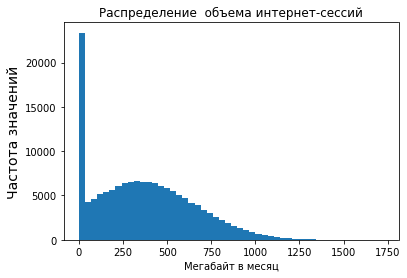

In [36]:
# гистограмма распределения объема интернет-сессий
plt.hist(df_internet['mb_used'], bins=50)
plt.xlabel("Мегабайт в месяц")
plt.ylabel("Частота значений", size=14)
plt.title("Распределение  объема интернет-сессий")
plt.show()

Многие клиенты не пользуются интернетом! Или клиенты пытались зайти в интернет, но не смогли, происходит обрыв сессий и звонков, возможно надо бить тревогу и бежать к технарям. Можно детально проанализировать город, время, клиент у кого произошел обрыв ...

### Подсчет объёма израсходованного интернет-трафика по месяцам для каждого абонента
1. Сгруппирую данные по абонентам и месяцам. Посчитаю объема интернет трафика для каждого абонента в месяц. 
2. Округлю результаты до гигабайт в большую сторону, приведу к целочисленному типу. 


In [37]:
# подсчет веб-трафика по пользователю по месяцам
df_internet_sum = df_internet.groupby(['user_id', 'month'])['mb_used'].sum()
# округление веб-трафика за месяц до гигабайт в большую сторону и приведение к целочисленному типу
df_internet_sum = np.ceil(df_internet_sum/1024).astype(int)
df_internet_sum

user_id  month
1000     5         3
         6        23
         7        14
         8        14
         9        15
                  ..
1498     10       21
1499     9         2
         10       18
         11       18
         12       13
Name: mb_used, Length: 3203, dtype: int64

### Добавление в общую таблицу данных веб-трафика по месяцам для каждого пользователя

In [38]:
# объединю общую таблицу data с таблицей интернет-трафика
data = data.merge(df_internet_sum, on=['user_id','month'], how='outer')
data.head()

,user_id,month,duration_x,duration_y,id,mb_used
0,1000,5,17.0,159.0,22.0,3.0
1,1000,6,28.0,172.0,60.0,23.0
2,1000,7,41.0,340.0,75.0,14.0
3,1000,8,42.0,408.0,81.0,14.0
4,1000,9,46.0,466.0,57.0,15.0


In [39]:
# переименую столбцы в соответствии с данными в них
data.columns = ['user_id', 'month', 'calls_count', 'calls_sum', 'messages', 'gb_used']
data.head()

,user_id,month,calls_count,calls_sum,messages,gb_used
0,1000,5,17.0,159.0,22.0,3.0
1,1000,6,28.0,172.0,60.0,23.0
2,1000,7,41.0,340.0,75.0,14.0
3,1000,8,42.0,408.0,81.0,14.0
4,1000,9,46.0,466.0,57.0,15.0


## Обработка данных абонентов

In [40]:
df_users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


В названиях всех столбцов таблицы df_users используются английские слова, строчные буквы, змеиный регистр. Видимых нарушений стиля нет. Дубликатов нет.

In [41]:
# Добавлю в общую таблицу data столбцы информацией о городе и тарифе клиента
df_users_cut = df_users[['user_id', 'city', 'tariff']]
data = data.merge(df_users_cut, on=['user_id'], how='outer')
data.head()

,user_id,month,calls_count,calls_sum,messages,gb_used,city,tariff
0,1000,5.0,17.0,159.0,22.0,3.0,Краснодар,ultra
1,1000,6.0,28.0,172.0,60.0,23.0,Краснодар,ultra
2,1000,7.0,41.0,340.0,75.0,14.0,Краснодар,ultra
3,1000,8.0,42.0,408.0,81.0,14.0,Краснодар,ultra
4,1000,9.0,46.0,466.0,57.0,15.0,Краснодар,ultra


In [42]:
# просмотрю таблицу с тарифами
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [43]:
# переименую столбец tariff_name в tariff для объединения таблиц
df_tariffs.rename(columns={"tariff_name":"tariff"} ,inplace=True)
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [44]:
# добавлю описание тарифов в общую таблицу 
data = data.merge(df_tariffs, on=['tariff'], how='outer')
data.head(5)

,user_id,month,calls_count,calls_sum,messages,gb_used,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,17.0,159.0,22.0,3.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1000,6.0,28.0,172.0,60.0,23.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
2,1000,7.0,41.0,340.0,75.0,14.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
3,1000,8.0,42.0,408.0,81.0,14.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
4,1000,9.0,46.0,466.0,57.0,15.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1


In [45]:
# Заполню пропуски нулями и приведу к целым числам:
data['calls_count'] = data['calls_count'].fillna(0).astype(int)
data['calls_sum'] = data['calls_sum'].fillna(0).astype(int)
data['messages'] = data['messages'].fillna(0).astype(int) 
data['gb_used'] = data['gb_used'].fillna(0).astype(int)   
data.head(5)

,user_id,month,calls_count,calls_sum,messages,gb_used,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,17,159,22,3,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1000,6.0,28,172,60,23,Краснодар,ultra,1000,30720,3000,1950,150,1,1
2,1000,7.0,41,340,75,14,Краснодар,ultra,1000,30720,3000,1950,150,1,1
3,1000,8.0,42,408,81,14,Краснодар,ultra,1000,30720,3000,1950,150,1,1
4,1000,9.0,46,466,57,15,Краснодар,ultra,1000,30720,3000,1950,150,1,1


In [46]:
# Переведу Мегабайты в Гигабайты 
data['mb_per_month_included'] = (data['mb_per_month_included']/1024).astype(int)
# Переименую колонку
data.rename(columns={'mb_per_month_included':'gb_per_month_included'} ,inplace=True)
data.head()

,user_id,month,calls_count,calls_sum,messages,gb_used,city,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,17,159,22,3,Краснодар,ultra,1000,30,3000,1950,150,1,1
1,1000,6.0,28,172,60,23,Краснодар,ultra,1000,30,3000,1950,150,1,1
2,1000,7.0,41,340,75,14,Краснодар,ultra,1000,30,3000,1950,150,1,1
3,1000,8.0,42,408,81,14,Краснодар,ultra,1000,30,3000,1950,150,1,1
4,1000,9.0,46,466,57,15,Краснодар,ultra,1000,30,3000,1950,150,1,1


In [47]:
# пользователи с пропусками в столбце month:
data.loc[data['month'].isna()]

,user_id,month,calls_count,calls_sum,messages,gb_used,city,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
985,1128,NaN,0,0,0,0,Волжский,ultra,1000,30,3000,1950,150,1,1
3215,1371,NaN,0,0,0,0,Омск,smart,50,15,500,550,200,3,3


In [48]:
# Таких всего двое. Посмотрю подробнее:
df_users.loc[(df_users['user_id'] == 1128)|(df_users['user_id'] == 1371)]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


Эти люди были клиенты компании меньше месяца. Но один раз тариф оплатили. 

In [49]:
# Заполню NaN в таблице data на месяц из подключения и приведу к целым числам:
data['month'] = data['month'].fillna(12).astype(int)
data.loc[(data['user_id'] == 1128)|(data['user_id'] == 1371)]

,user_id,month,calls_count,calls_sum,messages,gb_used,city,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
985,1128,12,0,0,0,0,Волжский,ultra,1000,30,3000,1950,150,1,1
3215,1371,12,0,0,0,0,Омск,smart,50,15,500,550,200,3,3


### Подсчет помесячной выручки с каждого пользователя

In [50]:
# помесячная выручка
# вычту включенные в тариф минуты из фактически использованных для каждого пользователя
# обнулю месяцы в которых не было превышения
data['over_cal'] = data['calls_sum'] - data['minutes_included']
data.loc[data['over_cal'] < 0, 'over_cal'] = 0
# вычту включенные в тариф сообщения из фактически использованных для каждого пользователя
# обнулю месяцы в которых не было превышения
data['over_mes'] = data['messages'] - data['messages_included']
data.loc[data['over_mes'] < 0, 'over_mes'] = 0
# вычту включенные в тариф гигабайты из фактически использованных для каждого пользователя
# обнулю месяцы в которых не было превышения
data['over_int'] = data['gb_used'] - data['gb_per_month_included']
data.loc[data['over_int'] < 0, 'over_int'] = 0
# помесячные расходы пользователей
data['user_month'] = data['rub_monthly_fee'] \
                    + data['over_cal'] * data['rub_per_minute'] \
                    + data['over_mes'] * data['rub_per_message'] \
                    + data['over_int'] * data['rub_per_gb']                  
data

,user_id,month,calls_count,calls_sum,messages,gb_used,city,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,over_cal,over_mes,over_int,user_month
0,1000,5,17,159,22,3,Краснодар,ultra,1000,30,3000,1950,150,1,1,0,0,0,1950
1,1000,6,28,172,60,23,Краснодар,ultra,1000,30,3000,1950,150,1,1,0,0,0,1950
2,1000,7,41,340,75,14,Краснодар,ultra,1000,30,3000,1950,150,1,1,0,0,0,1950
3,1000,8,42,408,81,14,Краснодар,ultra,1000,30,3000,1950,150,1,1,0,0,0,1950
4,1000,9,46,466,57,15,Краснодар,ultra,1000,30,3000,1950,150,1,1,0,0,0,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,9,0,0,32,17,Санкт-Петербург,smart,50,15,500,550,200,3,3,0,0,2,950
3212,1489,10,0,0,21,20,Санкт-Петербург,smart,50,15,500,550,200,3,3,0,0,5,1550
3213,1489,11,0,0,20,18,Санкт-Петербург,smart,50,15,500,550,200,3,3,0,0,3,1150
3214,1489,12,0,0,35,17,Санкт-Петербург,smart,50,15,500,550,200,3,3,0,0,2,950


In [51]:
# суммарная выручка всех абонентов за год.
data['user_month'].sum()

4916951

## Анализ расходов клиентов
Посмотрю, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитаю среднее количество, дисперсию и стандартное отклонение. Построю гистограммы. Опишу распределения.

In [52]:
# функция statistica печатает поясняющие заголовки, среднее, дисперсию и стандартное отклонение 
# для переданных заголовков и серии
def statistica (head_1, head_2, my_ser):
    print(head_1)
    print(head_2)
    print('    Среднее:', np.mean(my_ser))
    print('    Диспер.:', np.var(my_ser))
    print('    Ст.отк.:', np.std(my_ser))
    print()

In [53]:
# разделение клиентов по тарифам
data_smart = data[data['tariff'] == "smart"]
data_ultra = data[data['tariff'] == "ultra"]

### Звонки

In [54]:
# среднее, дисперсия и стандартное отклонение суммы звонков в месяц по тарифам
statistica('Тариф «Смарт»', 'Звонки:', data_smart['calls_sum'])
statistica('Тариф «Ультра»', 'Звонки:', data_ultra['calls_sum'])

Тариф «Смарт»
Звонки:
    Среднее: 417.747533632287
    Диспер.: 36265.12415310985
    Ст.отк.: 190.4340414765959

Тариф «Ультра»
Звонки:
    Среднее: 526.0892494929006
    Диспер.: 100950.00623331098
    Ст.отк.: 317.7263071155912



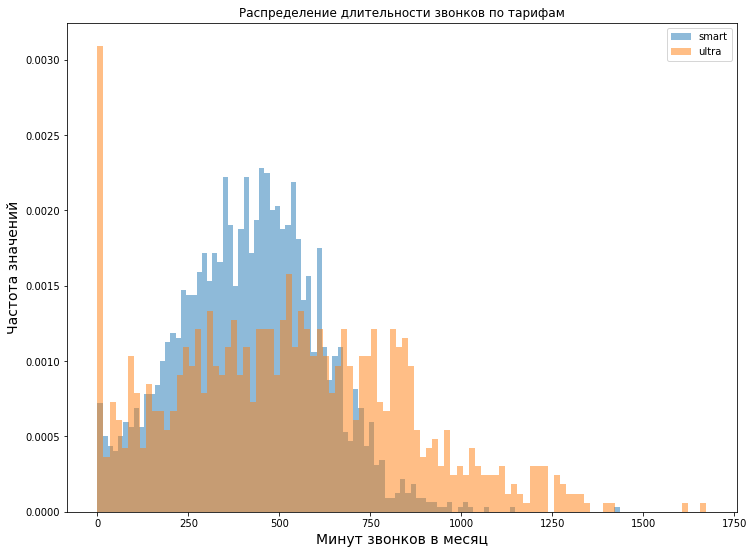

In [55]:
# гистограмма длительности звонков в месяц по тарифам
plt.figure(figsize=(12,9))
plt.hist(data_smart['calls_sum'], bins=100, alpha=0.5, label="smart", density=True)
plt.hist(data_ultra['calls_sum'], bins=100, alpha=0.5, label="ultra", density=True)
plt.xlabel("Минут звонков в месяц", size=14)
plt.ylabel("Частота значений", size=14)
plt.legend(loc='upper right')
plt.title("Распределение длительности звонков по тарифам")
plt.show()

**Вывод**

Длительность звонков абонентов тарифа "Смарт" распределена вокруг включенных в тариф 500 минут: +- 300 минут. Абоненты не часто превышают включенные в тариф минуты. Среди абонентов мало тех, кто почти не звонит. 

Абоненты тарифа "Ультра" никогда полностью не используют включенные в тариф 3000 минут. Частота расхода минут тарифа "Ультра" рапределена в диапазоне от 200 до 1000 минут. Среди абонентов тарифа "Ультра" много таких, кто почти не звонит.
### Сообщения

In [56]:
# среднее, дисперсия и стандартное отклонение числа сообщений в месяц по тарифам
statistica('Тариф «Смарт»', 'Сообщения:', data_smart['messages'])
statistica('Тариф «Ультра»', 'Сообщения:', data_ultra['messages'])

Тариф «Смарт»
Сообщения:
    Среднее: 33.36905829596412
    Диспер.: 796.5978766916688
    Ст.отк.: 28.224065559229217

Тариф «Ультра»
Сообщения:
    Среднее: 49.31338742393509
    Диспер.: 2283.0995570851965
    Ст.отк.: 47.781791061922284



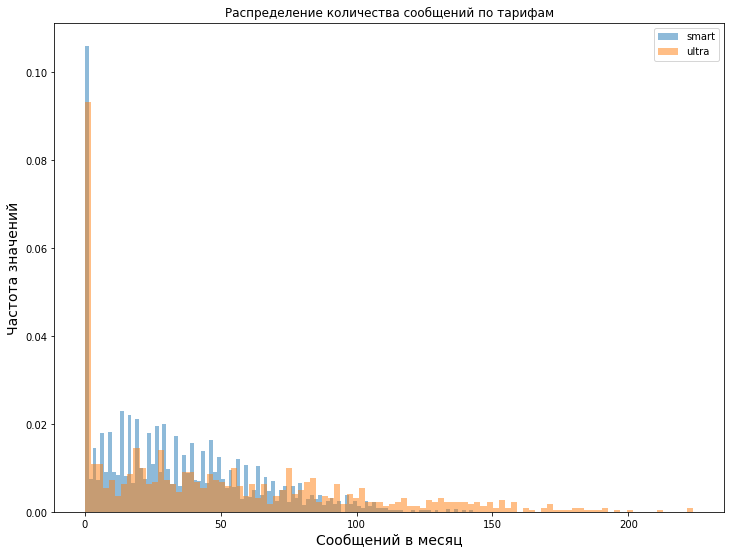

In [57]:
# гистограмма количества ообщений по тарифам
plt.figure(figsize=(12,9))
plt.hist(data_smart['messages'], bins=100, alpha=0.5, label="smart", density=True)
plt.hist(data_ultra['messages'], bins=100, alpha=0.5, label="ultra", density=True)
plt.xlabel("Сообщений в месяц", size=14)
plt.ylabel("Частота значений", size=14)
plt.legend(loc='upper right')
plt.title("Распределение количества сообщений по тарифам")
plt.show()

**Вывод**

Большая часть абонентов тарифа "Смарт" используют до 50 сообщений в месяц. Меньшая - до 100. Незначительная часть - до 150 сообщений в месяц. Среди абонентов тарифа "Смарт" много тех, кто не отправляет сообщений. 

Абоненты тарифа "Ультра" никогда полностью не используют включенные в тариф 1000 сообщений. Их потребность полностью покрывают 200 сообщений в месяц. Среди абонентов тарифа "Ультра" много тех, кто не отправляет сообщений.
### Интернет

In [58]:
# среднее, дисперсия и стандартное отклонение интернет трафика в месяц по тарифам
statistica('Тариф «Смарт»', 'Интернет трафик:', data_smart['gb_used'])
statistica('Тариф «Ультра»', 'Интернет трафик:', data_ultra['gb_used'])

Тариф «Смарт»
Интернет трафик:
    Среднее: 16.32152466367713
    Диспер.: 33.11859498481772
    Ст.отк.: 5.754875757548352

Тариф «Ультра»
Интернет трафик:
    Среднее: 19.474645030425965
    Диспер.: 97.27978308900676
    Ст.отк.: 9.863051408616238



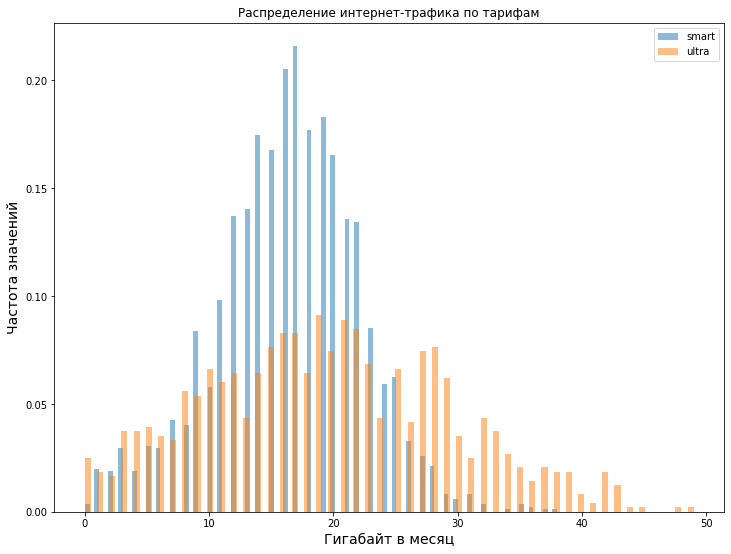

In [59]:
# гистограмма интернет-трафика по тарифам
plt.figure(figsize=(12,9))
plt.hist(data_smart['gb_used'], bins=100, alpha=0.5, label="smart", density=True)
plt.hist(data_ultra['gb_used'], bins=100, alpha=0.5, label="ultra", density=True)
plt.xlabel("Гигабайт в месяц", size=14)
plt.ylabel("Частота значений", size=14)
plt.legend(loc='upper right')
plt.title("Распределение интернет-трафика по тарифам")
plt.show()

**Вывод**

Абоненты тарифа "Смарт" в среднем расходуют больше включенных в тариф 15Гб интернет-трафика. Их потребность почти полностью покрывают 30Гб. Все абоненты этого тарифа используют мобильный интернет. 

Абоненты тарифа "Ультра" в среднем расходуют меньше включенных в тариф 30Гб интернет-трафика. Но среди них велика доля тех, кто расходует от 30 до 40Гб. Среди абонентов тарифа "Ультра" есть такие, кто почти не использует мобильный интернет.

## Проверка гипотез
### Гипотеза 1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Cформулирую нулевую гипотезу H₀: средняя выручка пользователей тарифов «Ультра» и «Смарт» равны. 
Альтернативная гипотеза H₁: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

У нас есть две независимых выборки выручки абонентов с разными тарифами за 2018 год. Нужно сравнить средние двух генеральных совокупностей выручек абонентов компании между собой. На основании имеющихся случайных выборок сделать вывод о том, считать ли средние выручки за эти периоды одинаковыми или нет.
Воспользуюсь методом для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: scipy.stats.ttest_ind.
Пороговое значение alpha задам 0.05.


In [60]:
# суммарная выручка всех абонентов за год.
data['user_month'].sum()

4916951

In [61]:
# среднее, дисперсия и стандартное отклонение выручки от пользователей в месяц по тарифам
print('Всего абонентов тарифа «Смарт»:', len(data_smart['user_id'].unique()))
print('Выручка всех абонентов тарифа за год:', data_smart['user_month'].sum())
statistica('Тариф «Смарт»', 'Выручка:', data_smart['user_month'])
print('Всего абонентов тарифа «Ультра»:', len(data_ultra['user_id'].unique()))
print('Выручка всех абонентов тарифа за год:', data_ultra['user_month'].sum())
statistica('Тариф «Ультра»', 'Выручка:', data_ultra['user_month'])

Всего абонентов тарифа «Смарт»: 351
Выручка всех абонентов тарифа за год: 2875901
Тариф «Смарт»
Выручка:
    Среднее: 1289.6417040358745
    Диспер.: 669430.4361979931
    Ст.отк.: 818.187286749185

Всего абонентов тарифа «Ультра»: 149
Выручка всех абонентов тарифа за год: 2041050
Тариф «Ультра»
Выручка:
    Среднее: 2070.030425963489
    Диспер.: 141244.31956107615
    Ст.отк.: 375.8248522398115



In [62]:
# проверка гипотезы о равенстве средних двух независимых совокупностей
# критический уровень статистической значимости
alpha = 0.05 
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(
    data_smart['user_month'], 
    data_ultra['user_month'],
    equal_var = False,  # дисперсии не равны
    nan_policy='omit') # игнорировать NaN

print('Гипотеза H₀: средняя выручка пользователей тарифов «Ультра» и «Смарт» равны.')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Гипотеза H₀: средняя выручка пользователей тарифов «Ультра» и «Смарт» равны.
p-значение: 1.927011394420941e-250
Отвергаем нулевую гипотезу


p-value - это вероятность получить наблюдаемую разницу в средней выручке пользователей разных тарифов совершенно случайно при условии, что нулевая гипотеза верна. Полученная вероянтость крайне мала (близка к нулю). Поэтому предположение о равенстве средней выручки пользователей тарифов «Ультра» и «Смарт» отвергнуто.

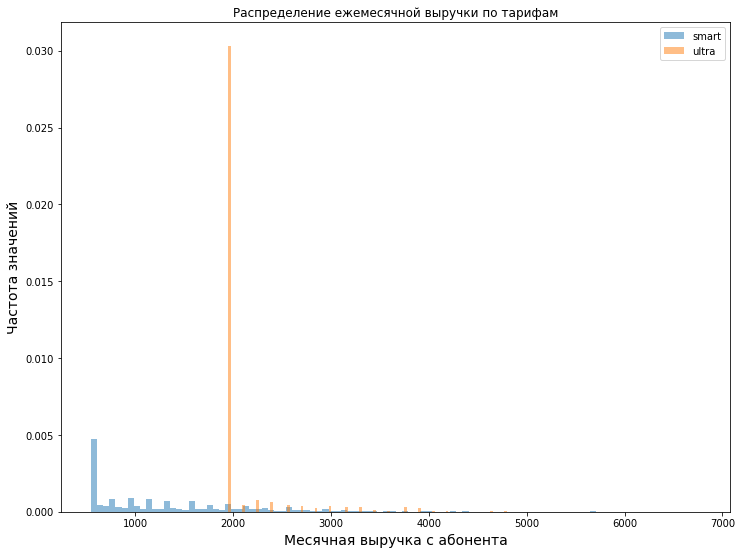

In [63]:
# гистограмма ежемесячной выручки по тарифам
plt.figure(figsize=(12,9))
plt.hist(data_smart['user_month'], bins=100, alpha=0.5, label="smart", density=True)
plt.hist(data_ultra['user_month'], bins=100, alpha=0.5, label="ultra", density=True)
plt.xlabel("Месячная выручка с абонента", size=14)
plt.ylabel("Частота значений", size=14)
plt.legend(loc='upper right')
plt.title("Распределение ежемесячной выручки по тарифам")
plt.show()

### Гипотеза 2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Cформулирую нулевую гипотезу H₀: средняя выручка пользователей из Москвы и других регионов равны. 
Альтернативная гипотеза H₁: средняя выручка пользователей из Москвы и других регионов различаются.

У нас есть две независимых выборки выручки абонентов из Москвы и других регионов за 2018 год. Нужно сравнить средние двух генеральных совокупностей выручек абонентов компании между собой. На основании имеющихся случайных выборок сделать вывод о том, считать ли средние выручки за эти периоды одинаковыми или нет.
Воспользуюсь методом для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: scipy.stats.ttest_ind.
Пороговое значение alpha задам 0.05.

In [64]:
# разделю всех абонентов на две группы: из Москвы и из регионов
data_moscow = data[data['city'] == "Москва"]
data_region = data[data['city'] != "Москва"]

# среднее, дисперсия и стандартное отклонение выручки от абонентов в месяц по регионам
statistica('Абоненты из Москвы', 'Выручка:', data_moscow['user_month'])
statistica('Абоненты из других регионов', 'Выручка:', data_region['user_month'])

Абоненты из Москвы
Выручка:
    Среднее: 1546.7135842880523
    Диспер.: 564710.7117467273
    Ст.отк.: 751.4723625967407

Абоненты из других регионов
Выручка:
    Среднее: 1524.7251439539348
    Диспер.: 653818.4925923498
    Ст.отк.: 808.5904356300226



In [65]:
# проверка гипотезы о равенстве средних двух независимых совокупностей
# критический уровень статистической значимости
alpha = 0.05 
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(
    data_moscow['user_month'], 
    data_region['user_month'],
    equal_var = False,  # дисперсии не равны
    nan_policy='omit') # игнорировать NaN

print('Гипотеза H₀: средняя выручка пользователей из Москвы и других регионов равны.')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Гипотеза H₀: средняя выручка пользователей из Москвы и других регионов равны.
p-значение: 0.5216952110000278
Не получилось отвергнуть нулевую гипотезу


p-value - это вероятность получить наблюдаемую разницу в средней выручке пользователей разных регионов совершенно случайно при условии, что нулевая гипотеза верна. Полученная вероятность очень велика. Поэтому предположение о равенстве средней выручки пользователей разных регионов не отвергнуто.

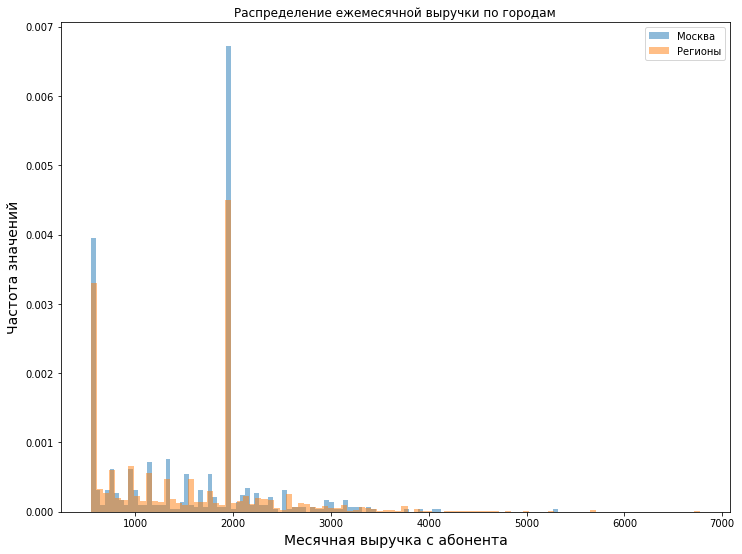

In [66]:
# гистограмма ежемесячной выручки по городам
plt.figure(figsize=(12,9))
plt.hist(data_moscow['user_month'], bins=100, alpha=0.5, label="Москва", density=True)
plt.hist(data_region['user_month'], bins=100, alpha=0.5, label="Регионы", density=True)
plt.xlabel("Месячная выручка с абонента", size=14)
plt.ylabel("Частота значений", size=14)
plt.legend(loc='upper right')
plt.title("Распределение ежемесячной выручки по городам")
plt.show()

## Вывод

В проведенном исследовании открыла и изучила файлы с данными. Исследовала их на пропуски и дубликаты. Изменила тип данных. 
Построила сводные таблицы и расчитала для каждого пользователя:
количество сделанных звонков и израсходованных минут разговора по месяцам;
количество отправленных сообщений по месяцам;
объем израсходованного интернет-трафика по месяцам;
помесячную выручку с каждого пользователя с учетом бесплатного лимита звонков, сообщений и интернет-трафика, тарифного плана и неполных месяцев использования тарифа.

**Пользователи тарифа «Смарт»** в среднем в месяц используют: 453 минуты звонков
36 сообщений и 
18 Гб интернет-трафика
Средняя выручка абонента в месяц 1410 рублей.
За 2018 год суммарная выручка всех абонентов тарифа "Смарт" составила 2776294.99 рублей

Длительность звонков абонентов тарифа "Смарт" распределена вокруг включенных в тариф 500 минут: +- 300 минут. Абоненты не часто превышают включенные в тариф минуты. Среди абонентов не много тех, кто почти не звонит.

**Пользователи тарифа «Ультра»** в среднем в месяц используют: 572 минуты звонков
53 сообщения и 
21 Гб интернет-трафика
Средняя выручка абонента в месяц 2102 рублей.
За 2018 год суммарная выручка всех абонентов тарифа «Ультра» составила 1876405.0 рублей.

Абоненты тарифа "Ультра" никогда полностью не используют включенные в тариф 3000 минут, 1000 сообщений, 30 Гб интернет-трафика. Частота расхода минут тарифа "Ультра" рапределена в диапазоне от 200 до 1000 минут. Среди абонентов тарифа "Ультра" много таких, кто почти не звонит.

**Проверила следующие гипотезы:**
1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» равны. Гипотеза отвергнута в пользу гипотезы "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются".
2. Средняя выручка пользователей из Москвы из других регионов равны. Не получилось отвергнуть эту гипотезу.  

**Итог:** Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются. Средняя выручка абонента тарифа "Ультра" составляет 2102 рублей в месяц, абонента тарифа "Смарт" - 1410 рублей. Но так как тариф "Смарт" дешевле "Ультра", а потому популярнее (351 пользователей против 149) , то в 2018 году на выборке 500 пользователей тариф "Смарт" принес компании больше денег (2776294 рублей против 1876405). Средняя выручка пользователей из Москвы и из других регионов одинаковы. 